In [7]:
from pathlib import Path
import numpy as np
import os
import shutil
from model_def import create_sdnet_model
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

In [2]:
IMG_TYPE = 'D'
ROOT_DIR = f'/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/'
DIR_IN = f'{ROOT_DIR}{IMG_TYPE}/'
DIR_TMP = f'{DIR_IN}/tmp/'
os.makedirs(DIR_TMP, exist_ok=True)

In [3]:
DIR_IN

'/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/D/'

# Load image paths

In [4]:
crack_paths = []
noncrack_paths = []
for i, path in enumerate(Path(DIR_IN).glob('**/*.jpg')):
    if not path.is_file():
        continue
    folder_type = path.parent.name[0]
    if folder_type != 'C' and folder_type != 'U':
        continue
        
    if path.parent.name[0] == 'C':
        crack_paths.append(path)
    else: 
        noncrack_paths.append(path)

In [5]:
n_crack = len(crack_paths)
n_noncrack = len(noncrack_paths)
n_total = n_crack + n_noncrack
print(f'number of all images = {n_total}')
print(f'number of crack images = {n_crack}')
print(f'number of non crack images = {n_noncrack}')
print(f'ratio crack/noncrack = {float(n_crack)/n_noncrack}')

number of all images = 27242
number of crack images = 4050
number of non crack images = 23192
ratio crack/noncrack = 0.1746291824767161


# split dataset into train, valid, test

In [87]:
paths_x = crack_paths + noncrack_paths
y = [1]*n_crack + [0]*n_noncrack
paths_train_x, paths_test_x,  train_y, test_y = train_test_split(paths_x, y,test_size=0.2)
paths_train_x, paths_valid_x, train_y, valid_y = train_test_split(paths_train_x, train_y, test_size=0.2)

for path in paths_train_x:
    rel_path = str(path.parents[0].name)+'/'+path.name
    path_dst = Path(f'{DIR_TMP}/train/{rel_path}')
    os.makedirs(path_dst.parents[0], exist_ok=True)
    shutil.copy(path, path_dst)

for path in paths_valid_x:
    rel_path = str(path.parents[0].name)+'/'+path.name
    path_dst = Path(f'{DIR_TMP}/valid/{rel_path}')
    os.makedirs(path_dst.parents[0], exist_ok=True)
    shutil.copy(path, path_dst) 

for path in paths_test_x:
    rel_path = str(path.parents[0].name)+'/'+path.name
    path_dst = Path(f'{DIR_TMP}/test/{rel_path}')
    os.makedirs(path_dst.parents[0], exist_ok=True)
    shutil.copy(path, path_dst) 

In [88]:
print(f'train size = {len(train_y)}, percent = {float(len(train_y))/n_total}')
print(f'valid size = {len(valid_y)}, percent = {float(len(valid_y))/n_total}')
print(f'test size  = {len(test_y)}, percent  = {float(len(test_y)) /n_total}')

train size = 8716, percent = 0.6399412628487519
valid size = 2180, percent = 0.16005873715124816
test size  = 2724, percent  = 0.2


# training

In [14]:
train_gen = ImageDataGenerator(rescale=1./255)
train_flow  = train_gen.flow_from_directory(
        f'{DIR_TMP}/train/',
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

valid_gen = ImageDataGenerator(rescale=1./255)
valid_flow  = train_gen.flow_from_directory(
        f'{DIR_TMP}/valid/',
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

test_gen = ImageDataGenerator(rescale=1./255)
test_flow  = train_gen.flow_from_directory(
        f'{DIR_TMP}/test/',
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

Found 8716 images belonging to 2 classes.
Found 2181 images belonging to 2 classes.
Found 2725 images belonging to 2 classes.


In [101]:
print('train:')
print(f'\tn = {len(train_flow.classes)}, n_crack = {np.sum(train_flow.classes == 0)}, n_noncrack = {np.sum(train_flow.classes == 1)}. ratio = {np.sum(train_flow.classes == 0)/np.sum(train_flow.classes == 1)}')

print('valid:')
print(f'\tn = {len(valid_flow.classes)}, n_crack = {np.sum(valid_flow.classes == 0)}, n_noncrack = {np.sum(valid_flow.classes == 1)}. ratio = {np.sum(valid_flow.classes == 0)/np.sum(valid_flow.classes == 1)}')

print('test:')
print(f'\tn = {len(test_flow.classes)}, n_crack = {np.sum(test_flow.classes == 0)}, n_noncrack = {np.sum(test_flow.classes == 1)}. ratio = {np.sum(test_flow.classes == 0)/np.sum(test_flow.classes == 1)}')

train:
	n = 8716, n_crack = 1284, n_noncrack = 7432. ratio = 0.1727664155005382
valid:
	n = 2181, n_crack = 319, n_noncrack = 1862. ratio = 0.17132116004296455
test:
	n = 2725, n_crack = 422, n_noncrack = 2303. ratio = 0.18323925314806774


In [93]:
%load_ext autoreload
%autoreload 2
from model_def import create_sdnet_model
model = create_sdnet_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_25 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_26 (Activation)   (None, 17, 17, 256)       0         
______________________________________________________

In [10]:
model_path = f'{ROOT_DIR}/models/weight_img_{IMG_TYPE}.hdf5'

In [20]:
from keras.callbacks import ModelCheckpoint

n_epochs = 10

check_point = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)

history = model.fit_generator(
        train_flow,
        steps_per_epoch=len(train_flow),
        epochs=n_epochs,
        validation_data=valid_flow,
        validation_steps=len(valid_flow), callbacks=[check_point])

Epoch 1/10
88/88 [==============================] - 13s 149ms/step - loss: 1.1619 - acc: 0.7396 - val_loss: 0.5453 - val_acc: 0.8519

Epoch 00001: val_loss improved from inf to 0.54532, saving model to /home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018//models/weight_img_D.hdf5
Epoch 2/10
88/88 [==============================] - 11s 127ms/step - loss: 0.4577 - acc: 0.8396 - val_loss: 0.4750 - val_acc: 0.8537

Epoch 00002: val_loss improved from 0.54532 to 0.47502, saving model to /home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018//models/weight_img_D.hdf5
Epoch 3/10
88/88 [==============================] - 11s 129ms/step - loss: 0.4607 - acc: 0.8405 - val_loss: 1.0675 - val_acc: 0.8556

Epoch 00003: val_loss did not improve from 0.47502
Epoch 4/10
88/88 [==============================] - 11s 129ms/step - loss: 0.4350 - acc: 0.8467 - val_loss: 0.5028 - val_acc: 0.8469

Epoch 00004: val_loss did not improve from 0.47502
Epoch 5/10
88/88 [======

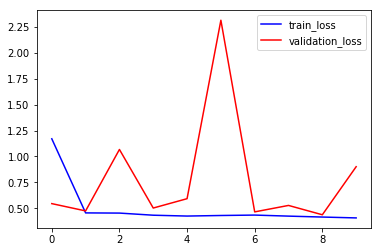

In [21]:
import matplotlib.pyplot as plt
x = np.arange(n_epochs)
plt.plot(x, history.history['loss'], '-b', label = 'train_loss')
plt.plot(x, history.history['val_loss'], '-r', label='validation_loss')
plt.legend()

# Accuracy on the same image type

In [66]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
def calc_accuracy(model, generator):
    preds = model.predict_generator(generator, steps=len(generator))
    preds_idx = np.argmax(preds, axis=1) # multiple categories
    class_names = [key for key in generator.class_indices.keys()]
    report = classification_report(generator.classes, preds_idx, target_names = class_names)
    return report

In [67]:
import numpy as np
model.load_weights(model_path)
report = calc_accuracy(model, test_flow)
print(report)

              precision    recall  f1-score   support

          CD       0.00      0.00      0.00       422
          UD       0.85      1.00      0.92      2303

   micro avg       0.84      0.84      0.84      2725
   macro avg       0.42      0.50      0.46      2725
weighted avg       0.71      0.84      0.77      2725



In [83]:
print(f'n_test_images = {len(test_flow.classes)}')
test_flow.class_indices

n_test_images = 2725


{'CD': 0, 'UD': 1}

In [82]:
preds = model.predict_generator(test_flow, steps=len(test_flow))
preds_idx = np.argmax(preds, axis=1) # multiple categories
n_crack_pred = np.sum(preds_idx == 0)
n_noncrack_pred = np.sum(preds_idx == 1)
print(f'n_crack_pred = {n_crack_pred}, n_noncrack_pred = {n_noncrack_pred}')

n_crack_pred = 0, n_noncrack_pred = 2725


# Accuracy on other image type

## image type P

In [68]:
IMG_TYPE_1 = 'P'
DIR_IN_1 = f'{ROOT_DIR}{IMG_TYPE_1}'
test_gen_1 = ImageDataGenerator(rescale=1.0/255)
test_flow_1 = test_gen_1.flow_from_directory(
        DIR_IN_1,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

Found 24334 images belonging to 2 classes.


In [69]:
test_flow_1.class_indices

{'CP': 0, 'UP': 1}

In [70]:
report = calc_accuracy(model, test_flow_1)

In [80]:
preds = model.predict_generator(test_flow_1, steps=len(test_flow_1))
preds_idx = np.argmax(preds, axis=1) # multiple categories
n_crack_pred = np.sum(preds_idx == 0)
n_noncrack_pred = np.sum(preds_idx == 1)
print(f'n_crack_pred = {n_crack_pred}, n_noncrack_pred = {n_noncrack_pred}')

n_crack_pred = 13, n_noncrack_pred = 24321


In [73]:
n_noncrack = np.sum(test_flow_1.classes == 1)
n_crack = np.sum(test_flow_1.classes == 0)
print(f'result of model trained on images of type {IMG_TYPE} on images of type {IMG_TYPE_1}')
print(f'\t n_crack = {n_crack}, n_noncrack = {n_noncrack}')
print(f'\t crack/noncrack ratio = {float(n_crack)/n_noncrack}')
print(f'\n{report}')

result of model trained on images of type D on images of type P
	 n_crack = 2608, n_noncrack = 21726
	 crack/noncrack ratio = 0.12004050446469668

              precision    recall  f1-score   support

          CP       0.15      0.00      0.00      2608
          UP       0.89      1.00      0.94     21726

   micro avg       0.89      0.89      0.89     24334
   macro avg       0.52      0.50      0.47     24334
weighted avg       0.81      0.89      0.84     24334



## image type W

In [52]:
IMG_TYPE_2 = 'W'
DIR_IN_2 = f'{ROOT_DIR}{IMG_TYPE_2}'
test_gen_2 = ImageDataGenerator(rescale=1.0/255)
test_flow_2 = test_gen_1.flow_from_directory(
        DIR_IN_2,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')
print(DIR_IN_2)

Found 18138 images belonging to 2 classes.
/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/W


In [53]:
test_flow_2.class_indices

{'CW': 0, 'UW': 1}

In [75]:
report = calc_accuracy(model, test_flow_2)

In [76]:
n_noncrack = np.sum(test_flow_2.classes == 1)
n_crack = np.sum(test_flow_2.classes == 0)
print(f'result of model trained on images of type {IMG_TYPE} on images of type {IMG_TYPE_2}')
print(f'\t n_crack = {n_crack}, n_noncrack = {n_noncrack}')
print(f'\t crack/noncrack ratio = {float(n_crack)/n_noncrack}')
print(f'\n {report}')

result of model trained on images of type D on images of type W
	 n_crack = 3851, n_noncrack = 14287
	 crack/noncrack ratio = 0.2695457408833205

               precision    recall  f1-score   support

          CW       0.20      0.00      0.00      3851
          UW       0.79      1.00      0.88     14287

   micro avg       0.79      0.79      0.79     18138
   macro avg       0.49      0.50      0.44     18138
weighted avg       0.66      0.79      0.69     18138

